In [0]:
import os
import re
import datetime
import numpy as np
from PIL import Image
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
def prepae_data():
    x, t = [], []

    categorized_dir_paths = glob('/content/drive/My Drive/kikagaku/novelapp/data/images/categorized-2/*')

    for dir_path in categorized_dir_paths:
        category_id = os.path.basename(dir_path)
        image_paths = glob(os.path.join(dir_path, '*'))
        print(datetime.datetime.now().isoformat(), 'Category', category_id, ':', len(image_paths))

        for i, p in enumerate(image_paths):
            book_id = re.sub(r'(_.*$)', '', os.path.basename(p))

            if i % 30 == 0:
                print(datetime.datetime.now().isoformat(), 'Image:', i, book_id, category_id)

            try:
                img = Image.open(p)
                img_resize = img.resize((229, 229))
                img_np = np.array(img_resize) / 255.0

                x.append(img_np)
                t.append(category_id)

            except Exception as e:
                print(datetime.datetime.now().isoformat(), 'Error:', e)

    return x, t

In [6]:
x, t = prepae_data()

2020-06-06T10:11:01.721225 Category 0 : 117
2020-06-06T10:11:01.721501 Image: 0 1015 0
2020-06-06T10:11:16.651649 Image: 30 1228 0
2020-06-06T10:11:36.145034 Image: 60 1106 0
2020-06-06T10:11:55.250031 Image: 90 1129 0
2020-06-06T10:12:13.751788 Category 1 : 119
2020-06-06T10:12:13.752464 Image: 0 3636 1
2020-06-06T10:12:39.012185 Image: 30 3722 1
2020-06-06T10:12:58.244038 Image: 60 3832 1
2020-06-06T10:13:18.831899 Image: 90 3777 1
2020-06-06T10:13:38.383322 Category 2 : 129
2020-06-06T10:13:38.384545 Image: 0 3601 2
2020-06-06T10:13:58.867030 Image: 30 3884 2
2020-06-06T10:14:17.750039 Image: 60 3778 2
2020-06-06T10:14:38.588967 Image: 90 3853 2
2020-06-06T10:14:59.618664 Image: 120 1502 2
2020-06-06T10:15:07.269138 Category 3 : 111
2020-06-06T10:15:07.270109 Image: 0 3312 3
2020-06-06T10:15:27.174965 Image: 30 2350 3
2020-06-06T10:15:46.240852 Image: 60 3010 3
2020-06-06T10:16:07.642203 Image: 90 3105 3


In [7]:
x = np.array(x).astype('f')
t = np.array(t).astype('f')
print(x.shape, t.shape)

(476, 229, 229, 3) (476,)


In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, t_train, t_val = train_test_split(x, t, test_size=0.3, random_state=0)

In [10]:
print(x_train.shape, x_val.shape)

(333, 229, 229, 3) (143, 229, 229, 3)


In [0]:
import os
import random

def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [0]:
reset_seed(0)

In [13]:
category_count = len(np.unique(t))
print(np.unique(t))
print(category_count)

[0. 1. 2. 3.]
4


In [0]:
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #rotation_range=180,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #vertical_flip=True
)

datagen.fit(x_train)

In [30]:
model_fine = Xception(include_top=False, weights='imagenet', input_shape=x_train.shape[1:])

for layer in model_fine.layers[:100]:
    layer.trainable = False

model = models.Sequential()
model.add(model_fine)

model.add(layers.Flatten())

model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(category_count, activation='softmax'))

optimizer = keras.optimizers.Adagrad(lr=0.005)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_3 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 100352)            401408    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                6422592   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 260       
Total params: 27,685,740
Trainable params: 16,101,900
Non-trainable params: 11,583,840
_________________________________

In [31]:
batch_size = 128
n_x_train = x_train.shape[0]
print(batch_size, n_x_train, n_x_train/batch_size)

128 333 2.6015625


In [32]:
print(datetime.datetime.now().isoformat(), 'Start')

history = model.fit_generator(
    datagen.flow(x_train, t_train, batch_size=batch_size),
    epochs=10,
    verbose=2,
    validation_data=(x_val, t_val),
    steps_per_epoch=n_x_train/batch_size,
)

print(datetime.datetime.now().isoformat(), 'End')

2020-06-06T10:46:31.115147 Start
Epoch 1/10
3/2 - 10s - loss: 8.6095 - accuracy: 0.2162 - val_loss: 5.5375 - val_accuracy: 0.2448
Epoch 2/10
3/2 - 5s - loss: 3.5674 - accuracy: 0.3694 - val_loss: 1.4771 - val_accuracy: 0.3077
Epoch 3/10
3/2 - 6s - loss: 1.3569 - accuracy: 0.3784 - val_loss: 1.3581 - val_accuracy: 0.3217
Epoch 4/10
3/2 - 5s - loss: 1.2794 - accuracy: 0.4384 - val_loss: 1.3488 - val_accuracy: 0.3007
Epoch 5/10
3/2 - 5s - loss: 1.2782 - accuracy: 0.4024 - val_loss: 1.3481 - val_accuracy: 0.3566
Epoch 6/10
3/2 - 6s - loss: 1.2202 - accuracy: 0.4414 - val_loss: 1.3504 - val_accuracy: 0.3427
Epoch 7/10
3/2 - 5s - loss: 1.2024 - accuracy: 0.4685 - val_loss: 1.3514 - val_accuracy: 0.3497
Epoch 8/10
3/2 - 5s - loss: 1.2197 - accuracy: 0.4625 - val_loss: 1.3532 - val_accuracy: 0.3287
Epoch 9/10
3/2 - 5s - loss: 1.1982 - accuracy: 0.4835 - val_loss: 1.3521 - val_accuracy: 0.3497
Epoch 10/10
3/2 - 5s - loss: 1.1534 - accuracy: 0.5195 - val_loss: 1.3503 - val_accuracy: 0.3566
2020-

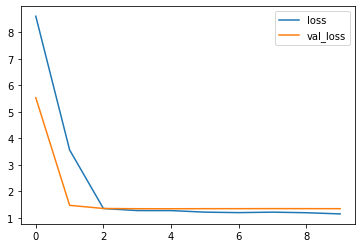

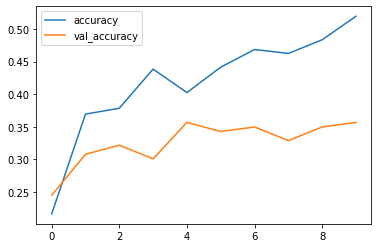

In [33]:
results = pd.DataFrame(history.history)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

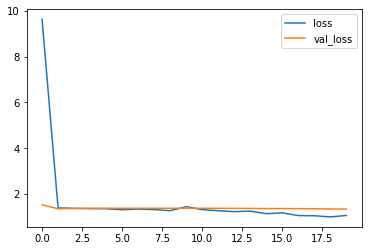

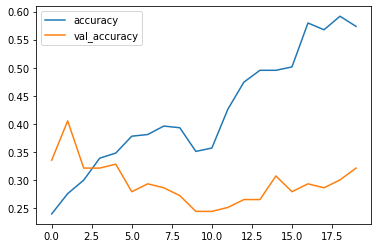

In [20]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()

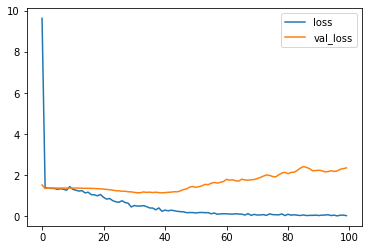

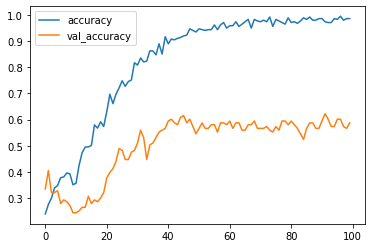

In [22]:
results = pd.concat([results, pd.DataFrame(history.history)], ignore_index=True)
results[['loss', 'val_loss']].plot()
results[['accuracy', 'val_accuracy']].plot()